In [86]:
run create_df.py

In [37]:
len(all_homes['light'])

12

In [16]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

In [4]:
def create_predictions(appliance="hvac", feature=['num_rooms', 'total_occupants'],k=2, weights='uniform'):
    
   
    out_month = {}
    gt_month = {}
    overall_dfs = {}
    df_pred_copy = df.copy()
    #df_pred_copy = dfs[appliance].copy()
    df_pred_copy = df_pred_copy.ix[all_homes[appliance]]
    for i, month in enumerate(["%s_%d" %(appliance,i) for i in range(1,13)]):
        y = df_pred_copy[month]
        y2 = y.dropna()
        y3 = y2[y2>appliance_min[appliance]].dropna()
        df3 = df_pred_copy[feature].ix[y3.index].dropna()
        
        #df3 = df.ix[y3.index].dropna()
        y3 = y3.ix[df3.index]
        #df3 = df3.ix[appliance_fhmm[appliance].index].dropna()
        #y3 = y3.ix[df3.index]
        from sklearn.cross_validation import LeaveOneOut
        from sklearn.neighbors import RadiusNeighborsRegressor
        #clf = RadiusNeighborsRegressor(radius=k)
        clf = KNeighborsRegressor(n_neighbors=k, weights=weights)
        #clf = KNeighborsRegressor(n_neighbors=k, weights = 'distance' )
        loo = LeaveOneOut(len(df3))
        out_pred = []

        for train, test in loo:
            #clf.fit(preprocessing.normalize(df3[feature_columns[feature]].values[train]), y3.values[train])
            clf.fit(df3[feature].values[train], y3.values[train])
            #out_pred.append(clf.predict(preprocessing.normalize(df3[feature_columns[feature]].values[test])))
            out_pred.append(clf.predict(df3[feature].values[test]))

        out_pred = np.hstack(out_pred)

        out_month[i+1] = out_pred
        gt_month[i+1] = y3.values
        overall_dfs[i+1] = pd.DataFrame({"gt":y3.values, "pred":out_pred,
                                              "gt_total":dfc.ix[y3.index]["aggregate_"+str(i+1)].values}, index=y3.index)
        overall_dfs[i+1]["national average"] = overall_dfs[i+1]["gt_total"]*national_average[appliance]
    return overall_dfs

def percentage_error(gt, pred):
    return 100*np.abs(gt-pred)/(gt)




def compute_metrics(df):
    temp = df[df.gt_total>0.0]
    temp = temp[temp.gt>temp.gt_total]
    return {"Percentage error in appliance energy":np.median(percentage_error(df["gt"], df["pred"]))
            }

### Finding outliers based on training set

In [25]:
%matplotlib qt

In [10]:
st = pd.HDFStore("/Users/nipunbatra/Downloads/wiki-temp.h5")

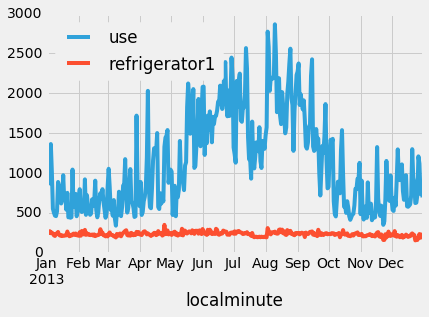

In [39]:
st['/5371']['2013'][['use','refrigerator1']].resample("1D").tail(1000).plot()

In [58]:
df.ix[all_homes['fridge']]['fridge_11']

94       47.922897
370      45.972420
410      40.078674
545      38.202076
624      31.260502
1953     36.772598
2156     46.742928
2242     53.064209
2814     49.627625
3367     60.005070
3456     65.999664
3723     56.788586
3967     37.565613
4767     45.823704
5357     50.360394
5371    157.175964
6072     97.733780
6636     70.098412
6910     63.587074
7769     35.914795
7866     37.428440
Name: fridge_11, dtype: float64

In [59]:
def criterion_function(feature_set):
    global k
    
    
    temp = create_predictions(appliance, feature_set, k=k)
    errors = {}
    for i in range(1, 13):
        errors[i] = percentage_error(temp[i]["gt"], temp[i]["pred"])
    error_df = pd.DataFrame(errors)
    accur_df = 100-error_df
    accur_df[accur_df<0]=0
   
    if appliance is "hvac":
         tdf = accur_df[range(5, 11)]
    else:
        tdf = accur_df
    #print tdf.dropna().median().mean(), feature_set
    return tdf.dropna().median().mean()

In [60]:
def seq_forw_select(features, max_k, criterion_func, print_steps=False):
    """
    Implementation of a Sequential Forward Selection algorithm.
    
    Keyword Arguments:
        features (list): The feature space as a list of features.
        max_k: Termination criterion; the size of the returned feature subset.
        criterion_func (function): Function that is used to evaluate the
            performance of the feature subset.
        print_steps (bool): Prints the algorithm procedure if True.
    
    Returns the selected feature subset, a list of features of length max_k.

    """

    # Initialization
    feat_sub = []
    k = 0
    d = len(features)
    if max_k > d:
        max_k = d

    while True:

        # Inclusion step
        
        crit_func_max = criterion_func(feat_sub + [features[0]])
        best_feat = features[0]
        for x in features[1:]:
            crit_func_eval = criterion_func(feat_sub + [x])
            if crit_func_eval > crit_func_max:
                crit_func_max = crit_func_eval
                best_feat = x
        feat_sub.append(best_feat)
        if print_steps:
            print('include: {} -> feature_subset: {}. Accuracy: {}'.format(best_feat, feat_sub, crit_func_max))
        features.remove(best_feat)

        # Termination condition
        k = len(feat_sub)
        if k == max_k:
            break

    return feat_sub

In [61]:
all_features = np.hstack([["aggregate_%d" %i for i in range(1,13)],
            ["fraction_%d" %i for i in range(1,25)],
         "autocorr",
         "max_seasonal_12",
       
        "max_trend_12",
        
        "max_seasonal_daily",
        
        "max_trend_daily",
        
         "max_seasonal_weekly",
        
        "max_trend_weekly",
        
        "disag_fridge",
        "cluster_small",
        "cluster_big",
        "lt_500",
        "bet_500_1000",
        "gt_1000",
        "temperature_corr",
         ["daily_usage_%d" %i for i in range(1,8)],
        "area",
        "num_rooms",
        "mins_hvac",
        "total_occupants",
               ['ratio_min_max', 'difference_min_max',
                                        'ratio_difference_min_max'],
               ["seasonal_energy_%d" %i for i in range(5,11)],
        ["fft_%d" %i for i in range(1, 6)]

           ])

ami_features = np.hstack([["aggregate_%d" %i for i in range(1,13)],
            ["fraction_%d" %i for i in range(1,25)],
         "autocorr",
         "max_seasonal_12",
       
        "max_trend_12",
       
        "max_seasonal_daily",
       
        "max_trend_daily",
        
         "max_seasonal_weekly",
        
        "max_trend_weekly",
        
        "disag_fridge",
        "cluster_small",
        "cluster_big",
        "lt_500",
        "bet_500_1000",
        "gt_1000",
        "temperature_corr",
         ["daily_usage_%d" %i for i in range(1,8)],
        ['ratio_min_max', 'difference_min_max',
                                        'ratio_difference_min_max'],
               ["seasonal_energy_%d" %i for i in range(5,11)],
        ["fft_%d" %i for i in range(1, 6)]

           ])

only_monthly_features =  np.hstack([["aggregate_%d" %i for i in range(1,13)],
                                    ['ratio_min_max', 'difference_min_max',
                                        'ratio_difference_min_max']])

monthly_plus_static_features = np.hstack([["aggregate_%d" %i for i in range(1,13)],
            
        "area",
        "num_rooms",
        "mins_hvac",
        "total_occupants",
               ['ratio_min_max', 'difference_min_max',
                                        'ratio_difference_min_max'],
               ])


In [62]:
hvac_all_features = all_features.tolist()
def remove_hvac_features(fe):

    hvac_all_features = [x for x in fe if 'daily_usage' not in x]
    hvac_all_features = [x for x in hvac_all_features if 'stdev_trend' not in x]
    hvac_all_features = [x for x in hvac_all_features if 'stdev_seasonal' not in x]
    hvac_all_features = [x for x in hvac_all_features if 'variance' not in x]
    hvac_all_features = [x for x in hvac_all_features if 'mins_hvac' not in x]
    hvac_all_features = [x for x in hvac_all_features if 'fraction' not in x]
    return hvac_all_features


In [63]:
ft

NameError: name 'ft' is not defined

In [64]:
from copy import deepcopy

out = {}
optimal_dict = {}
for appliance in ["fridge"]:
    feature_map = {
    "15 min AMI": remove_hvac_features(ami_features.tolist()),
    "Monthly": remove_hvac_features(only_monthly_features.tolist()),
    "Monthly+Static":remove_hvac_features(monthly_plus_static_features.tolist()),
    "All":remove_hvac_features(all_features.tolist())
    }

    print "%"*40
    print appliance
    print "%"*40
    out[appliance] = {}
    optimal_dict[appliance] = {}
    for feature_name, ft in deepcopy(feature_map).items():
        
        best_overall_f = []
        best_overall_accur = 0
        best_k=-1
        out[appliance][feature_name] = {}
        optimal_dict[appliance][feature_name] = {}
        print "*"*20
        print feature_name
        print "*"*20
        for k in range(1, 7):
            global k
            ftc = deepcopy(ft)
            out[appliance][feature_name][k] = {}
            
            best=seq_forw_select(features=ftc, max_k=8,
                          criterion_func=criterion_function, print_steps=False)
            
            
            best_accur = 0.0
            best_f = []
            for i in range(1, len(best)):
                if criterion_function(best[:i])>best_accur:
                    best_accur = criterion_function(best[:i])
                    best_f = best[:i]
            out[appliance][feature_name][k]["f"] = best_f
            out[appliance][feature_name][k]["accuracy"]=best_accur

            if best_accur>best_overall_accur:
                best_overall_f = best_f
                best_overall_accur = best_accur
                best_k = k
       
        print best_k, best_overall_f, best_overall_accur
        print "-"*80

        optimal_dict[appliance][feature_name] = {"accuracy":best_overall_accur, "f":best_overall_f,"k":best_k}       

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
fridge
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
********************
Monthly
********************
4 ['aggregate_7', 'difference_min_max', 'ratio_min_max', 'aggregate_2'] 82.3579111068
--------------------------------------------------------------------------------
********************
All
********************
1 ['aggregate_1', 'aggregate_9', 'max_seasonal_12', 'total_occupants', 'aggregate_12', 'aggregate_7', 'aggregate_4'] 86.2197167308
--------------------------------------------------------------------------------
********************
15 min AMI
********************
3 ['gt_1000', 'ratio_min_max', 'aggregate_3', 'ratio_difference_min_max', 'bet_500_1000'] 85.7201556496
--------------------------------------------------------------------------------
********************
Monthly+Static
********************


<ipython-input-64-5eaabbeb2532>:29: SyntaxWarning: name 'k' is assigned to before global declaration
  global k


KeyboardInterrupt: 

In [ ]:
map(len, feature_map.values())

In [63]:
!head out.json

{"hvac": {"Monthly": {"1": {"accuracy": 82.267100092164398, "f": ["aggregate_5", "aggregate_7", "aggregate_4", "aggregate_3"]}, "2": {"accuracy": 85.414235440491211, "f": ["aggregate_7", "aggregate_9", "aggregate_12", "aggregate_5"]}, "3": {"accuracy": 85.129610344195854, "f": ["aggregate_7", "aggregate_5", "aggregate_3"]}, "4": {"accuracy": 85.662417454734609, "f": ["aggregate_7", "aggregate_6", "aggregate_11"]}, "5": {"accuracy": 85.272819356503916, "f": ["aggregate_7", "aggregate_11", "aggregate_1", "difference_min_max", "aggregate_10"]}, "6": {"accuracy": 86.424022369359406, "f": ["aggregate_7", "aggregate_11", "aggregate_8", "aggregate_12"]}}, "All": {"1": {"accuracy": 83.283166337616493, "f": ["aggregate_5", "daily_usage_1", "daily_usage_4", "daily_usage_6"]}, "2": {"accuracy": 84.54986955323362, "f": ["aggregate_7", "seasonal_energy_8", "max_trend_weekly", "aggregate_5", "seasonal_energy_7"]}, "3": {"accuracy": 85.49928240834879, "f": ["aggregate_7", "daily_usage_3", "aggregate_

In [39]:
oracle = pd.Series({'dw':64, 'fridge':94,'light':100, 'wm':77, 'dr': 64, 'hvac':95 }).to_dict()


In [40]:
accur_df = {}
for appliance in ['hvac','fridge','wm','dr','dw','light']:
    accur_df[appliance] = pd.DataFrame(optimal_dict[appliance]).ix['accuracy'].to_dict()
    accur_df[appliance]["Oracle"] = oracle[appliance]

In [54]:
appliance="hvac"
k=6
criterion_function(['aggregate_7', 'aggregate_11', 'aggregate_8', 'aggregate_12'])

86.424022369359406

In [56]:
import json

In [57]:
json.dump(optimal_dict, open("optimal_dict.json", 'w'))

In [58]:
json.dump(out, open("out.json", 'w'))

In [60]:
out['hvac']

{'15 min AMI': {1: {'accuracy': 83.283166337616493,
   'f': ['aggregate_5', 'daily_usage_1', 'daily_usage_4', 'daily_usage_6']},
  2: {'accuracy': 84.54986955323362,
   'f': ['aggregate_7',
    'seasonal_energy_8',
    'max_trend_weekly',
    'aggregate_5',
    'seasonal_energy_7']},
  3: {'accuracy': 85.49928240834879,
   'f': ['aggregate_7',
    'daily_usage_3',
    'aggregate_5',
    'daily_usage_2',
    'aggregate_1',
    'aggregate_6',
    'daily_usage_4']},
  4: {'accuracy': 85.689383148053494,
   'f': ['aggregate_7',
    'daily_usage_3',
    'daily_usage_1',
    'aggregate_5',
    'aggregate_3',
    'daily_usage_4',
    'aggregate_1']},
  5: {'accuracy': 85.461772623401998,
   'f': ['aggregate_7',
    'daily_usage_3',
    'bet_500_1000',
    'gt_1000',
    'aggregate_8',
    'difference_min_max',
    'aggregate_12']},
  6: {'accuracy': 86.463370085906362,
   'f': ['aggregate_7',
    'aggregate_11',
    'aggregate_8',
    'aggregate_12',
    'daily_usage_3']}},
 'All': {1: {'accu

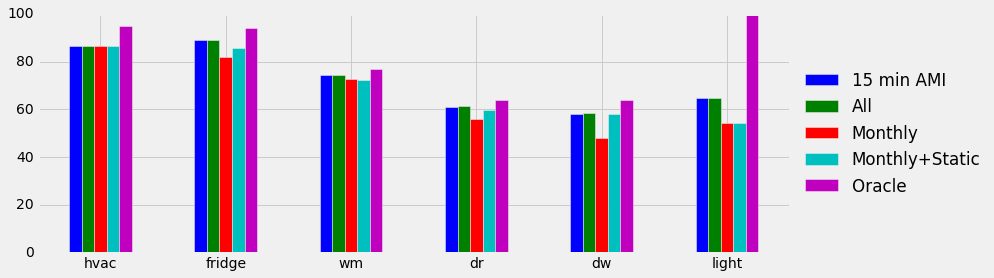

In [50]:
pd.DataFrame(accur_df)[['hvac','fridge','wm','dr','dw','light']].T.plot(figsize=(12,4), kind="bar", rot=0).legend(loc='center left', bbox_to_anchor=(1, 0.5))
#ax = plt.gca()
#for p in ax.patches:
#    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

In [ ]:
out

In [ ]:
#for appliance in ["fridge","wm","light","dr","dw"]:
for appliance in ["wm"]:
    print "*"*20
    print appliance
    print "*"*20
    for k in range(4, 5):
        print "+"*20
        print k
        best=seq_forw_select(features=a.tolist(), max_k=15,
                      criterion_func=criterion_function, print_steps=True)
        
        

In [ ]:
temp=create_predictions('wm',['daily_usage_1', 'aggregate_11', 'aggregate_10', 'bet_500_1000', 'aggregate_4'],k=4)

In [ ]:
errors = {}
for i in range(1, 13):
    errors[i] = percentage_error(temp[i]["gt"], temp[i]["pred"])
error_df = pd.DataFrame(errors)
accur_df = 100-error_df
accur_df[accur_df<0]=0

In [ ]:
accur_df.dropna().median().mean()

In [ ]:
accur_df[range(5, 11)].dropna().median().mean()

In [ ]:
home = 1334
train_df = df.ix[all_homes["hvac"]].drop(home)
test_df = df.ix[home]
appliance="hvac"
month=9

def create_predictions_linear(appliance="hvac", feature=['num_rooms', 'total_occupants'] ):
    
   
    out_month = {}
    gt_month = {}
    overall_dfs = {}
    df_pred_copy = df.copy()
    #df_pred_copy = dfs[appliance].copy()
    df_pred_copy = df_pred_copy.ix[all_homes[appliance]]
    for i, month in enumerate(["%s_%d" %(appliance,i) for i in range(1,13)]):
        y = df_pred_copy[month]
        y2 = y.dropna()
        y3 = y2[y2>appliance_min[appliance]].dropna()
        df3 = df_pred_copy[feature].ix[y3.index].dropna()
        
        #df3 = df.ix[y3.index].dropna()
        y3 = y3.ix[df3.index]
        #df3 = df3.ix[appliance_fhmm[appliance].index].dropna()
        #y3 = y3.ix[df3.index]
        from sklearn.cross_validation import LeaveOneOut
        from sklearn.neighbors import RadiusNeighborsRegressor
        from sklearn.linear_model import LinearRegression
        clf = LinearRegression()
        #clf = RadiusNeighborsRegressor(radius=k)
        #clf = KNeighborsRegressor(n_neighbors=k, weights=weights)
        #clf = KNeighborsRegressor(n_neighbors=k, weights = 'distance' )
        loo = LeaveOneOut(len(df3))
        out_pred = []

        for train, test in loo:
            #clf.fit(preprocessing.normalize(df3[feature_columns[feature]].values[train]), y3.values[train])
            clf.fit(df3[feature].values[train], y3.values[train])
            #out_pred.append(clf.predict(preprocessing.normalize(df3[feature_columns[feature]].values[test])))
            out_pred.append(clf.predict(df3[feature].values[test]))

        out_pred = np.hstack(out_pred)

        out_month[i+1] = out_pred
        gt_month[i+1] = y3.values
        overall_dfs[i+1] = pd.DataFrame({"gt":y3.values, "pred":out_pred,
                                              "gt_total":dfc.ix[y3.index]["aggregate_"+str(i+1)].values}, index=y3.index)
        overall_dfs[i+1]["national average"] = overall_dfs[i+1]["gt_total"]*national_average[appliance]
    return overall_dfs

def predict_linear(features):
    from sklearn.linear_model import LinearRegression
    l = LinearRegression()
    l.fit(train_df[features], train_df["%s_%d" %(appliance, month)])
    pred = l.predict(test_df[features])
    gt = test_df["%s_%d" %(appliance, month)]
    error = np.abs(pred-gt)/gt
    error_percentage = 100*error
    accur = 100-error_percentage
    if accur<0:
        accur=0
    return accur


In [ ]:
hvac_all_features

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
best=seq_forw_select(features=a.tolist(), max_k=15,
                      criterion_func=predict_linear, print_steps=True)

In [ ]:
for appliance in ["dw"]:
    print "*"*20
    print appliance
    print "*"*20
    for k in range(2, 8):
        print "+"*20
        print k
        best=seq_forw_select(features=a.tolist(), max_k=10,
                      criterion_func=criterion_function, print_steps=True)

In [ ]:
feature = ['aggregate_6']

In [ ]:
k=2

In [ ]:
temp = create_predictions('hvac',feature, 2)

In [ ]:
errors = {}
for i in range(1, 13):
    errors[i] = percentage_error(temp[i]["gt"], temp[i]["pred"])
error_df = pd.DataFrame(errors)
accur_df = 100-error_df
accur_df[accur_df<0]=0

In [ ]:
accur_df[range(5, 11)].dropna().mean(axis=1)

In [ ]:
def criterion_function_lin(feature_set):
    
    
    temp = create_predictions_lin(appliance, feature_set, month)
    errors = {}
    for i in range(1, 13):
        errors[i] = percentage_error(temp[i]["gt"], temp[i]["pred"])
    error_df = pd.DataFrame(errors)
    accur_df = 100-error_df
    accur_df[accur_df<0]=0
   
    if appliance is "hvac":
         tdf = accur_df[range(5, 11)]
    else:
        tdf = accur_df
    #print tdf.dropna().median().mean(), feature_set
    return tdf.dropna().median().mean()

In [ ]:
accur_df[range(5, 11)].dropna().median().mean()

In [ ]:
len(accur_df.dropna().mean(axis=1).index)

In [ ]:
accur_df.dropna().median().mean()

In [ ]:
accur_df.dropna().mean(axis=1).index

In [ ]:
all_homes["wm"]

In [ ]:
accur_df.dropna().mean(axis=1)

In [ ]:
%matplotlib inline

In [ ]:
m=6
wm = 'hvac_%d' %m
feature_plot="fft_5"
df.ix[all_homes["hvac"]][[feature_plot,wm]].plot(kind="scatter", x=feature_plot,y=wm)
df.ix[all_homes["hvac"]][[feature_plot,wm]].corr()

In [ ]:
temp = create_predictions('wm',['area'],1)
errors = {}
for i in range(1, 13):
    errors[i] = percentage_error(temp[i]["gt"], temp[i]["pred"])
error_df = pd.DataFrame(errors)
accur_df = 100-error_df
accur_df[accur_df<0]=0

In [ ]:
accur_df.dropna().median()

In [ ]:
all_homes['dw']

In [ ]:
st = pd.HDFStore("/Users/nipunbatra/Downloads/wiki-temp.h5")
out_dw = {}
for home in all_homes['dw']:
    a = st['/%d' %home]['2013']['dishwasher1'].resample("15T")
    print home
    out_dw[home] = {'bet_500_1000':len(a.diff().abs()[(a.diff().abs()>500) & (a.diff().abs()<1000)]),
                    'gt_1000':len(a.diff().abs()[(a.diff().abs()>1000)])}

In [ ]:
df.ix[all_homes['dw']].bet_500_1000

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.scatter(pd.Series(out_dw), df.ix[all_homes['dw']].bet_500_1000)
#.corr(df.ix[all_homes['dw']].bet_500_1000)

In [ ]:
pd.Series(out_dw['bet_500_1000']).corr(df.ix[all_homes['dw']].bet_500_1000)

In [ ]:
pd.DataFrame(out_dw).T.corrwith(df.ix[all_homes['dw']].bet_500_1000)

In [ ]:
plt.scatter(df.ix[all_homes['dw']].bet_500_1000, pd.DataFrame(out_dw).T['bet_500_1000'])
plt.xlabel("Fraction of step changes in \naggregate between 500 and 1000W")
plt.ylabel("#Step changes in Dish washer \nstream between 500 and 1000W")
plt.title(df.ix[all_homes['dw']].bet_500_1000.corr(pd.DataFrame(out_dw).T['bet_500_1000']))
plt.tight_layout()
plt.savefig("/Users/nipunbatra/git/monthly-disaggregation/figures/new/dw_aggregate_step_changes.png")

In [ ]:
df.ix[all_homes['dw']]['dw_5']